In [42]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# 1) LOAD DATA
df = pd.read_csv("blood_transfusion.csv")

# Heuristic target detection: pick a known name or any binary column
known_targets = {
    "class","target","donated","label",
    "made donation in march 2007","made_donation","whether donated","donation"
}
lower_map = {c: c.lower() for c in df.columns}
candidates = []
for c in df.columns:
    if lower_map[c] in known_targets or df[c].nunique(dropna=True) <= 2:
        candidates.append(c)
target_col = candidates[-1] if candidates else df.columns[-1]

# Map common string targets to 0/1 if needed
if df[target_col].dtype == object:
    mapping = {"yes":1,"y":1,"true":1,"t":1,"1":1, "no":0,"n":0,"false":0,"f":0,"0":0}
    df[target_col] = df[target_col].astype(str).str.lower().map(mapping).fillna(df[target_col])

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Target column (heuristic):", target_col)
display(df.head(10))
display(df.describe(include="all"))


Shape: (748, 5)
Columns: ['Recency', 'Frequency', 'Monetary', 'Time', 'Class']
Target column (heuristic): Class


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated
5,4,4,1000,4,not donated
6,2,7,1750,14,donated
7,1,12,3000,35,not donated
8,2,9,2250,22,donated
9,5,46,11500,98,donated


,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,not donated
freq,NaN,NaN,NaN,NaN,570
mean,9.506684,5.514706,1378.676471,34.282086,NaN
std,8.095396,5.839307,1459.826781,24.376714,NaN
min,0.000000,1.000000,250.000000,2.000000,NaN
25%,2.750000,2.000000,500.000000,16.000000,NaN
50%,7.000000,4.000000,1000.000000,28.000000,NaN
75%,14.000000,7.000000,1750.000000,50.000000,NaN


In [43]:
# 3) CLEANING
cleaning_notes = []
na_counts = df.isna().sum()
if na_counts.sum() == 0:
    cleaning_notes.append("No missing values detected.")
else:
    for col in df.columns:
        if df[col].isna().any():
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].fillna(df[col].median())
                cleaning_notes.append(f"{col}: filled numeric NA with median.")
            else:
                mode = df[col].mode()
                fill_val = mode.iloc[0] if len(mode) else "Unknown"
                df[col] = df[col].fillna(fill_val)
                cleaning_notes.append(f"{col}: filled categorical NA with mode/‘Unknown’.")
print("\n".join(cleaning_notes) if cleaning_notes else "No cleaning applied.")


No missing values detected.


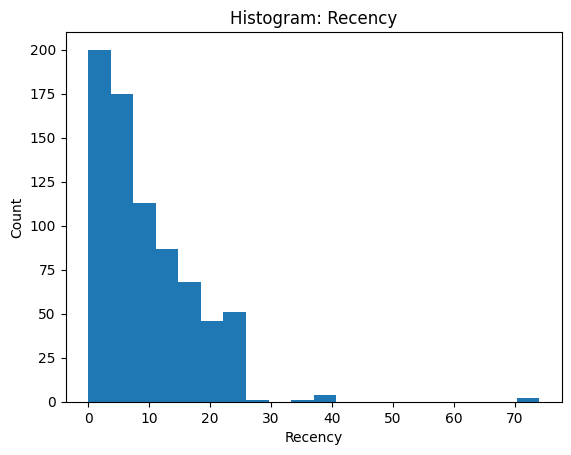

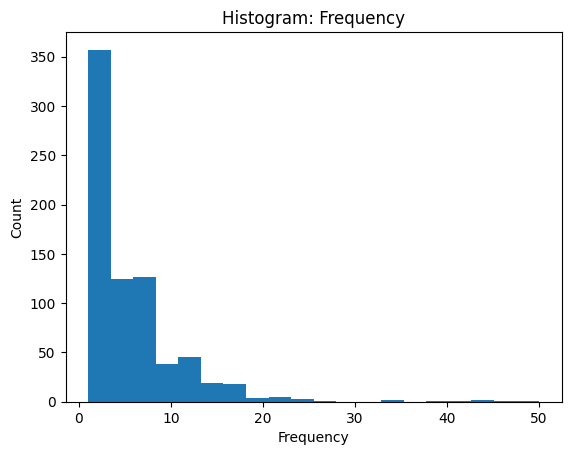

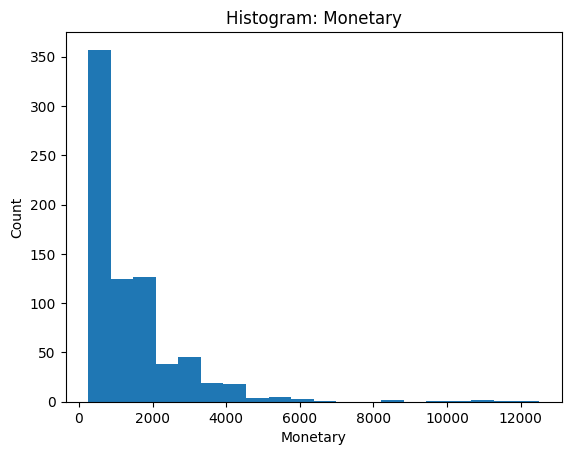

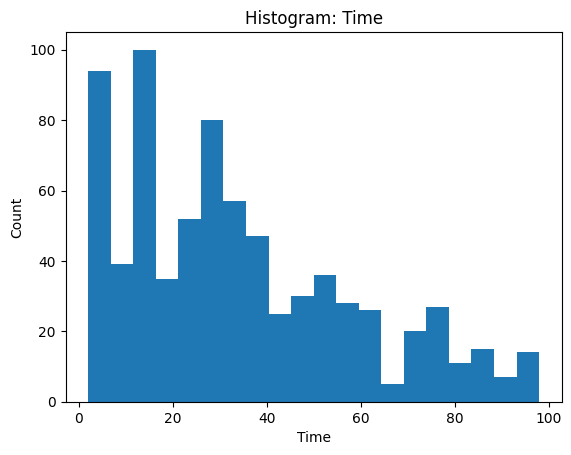

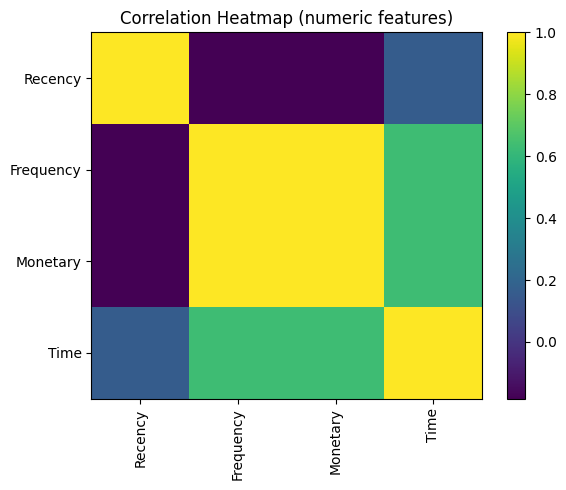

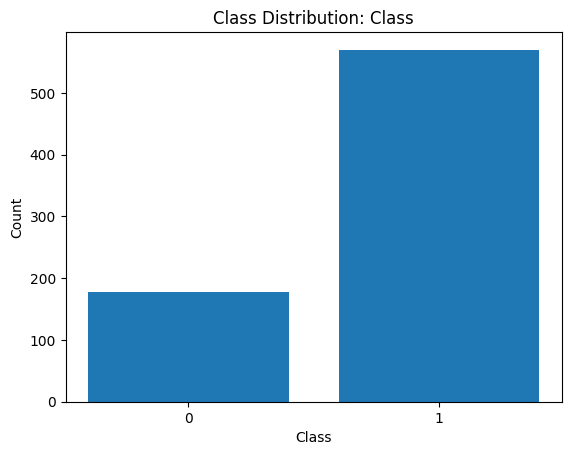

Class counts: {0: 178, 1: 570}


In [44]:
import matplotlib.pyplot as plt

features = [c for c in df.columns if c != target_col]
X_raw = df[features].copy()
y = df[target_col].copy()

# Ensure binary numeric target if it’s a two-class categorical
if not pd.api.types.is_numeric_dtype(y) and y.nunique()==2:
    y = y.astype('category').cat.codes

num_cols = [c for c in X_raw.columns if pd.api.types.is_numeric_dtype(X_raw[c])]

# Histograms
for col in num_cols:
    plt.figure()
    plt.hist(X_raw[col].dropna(), bins=20)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

# Correlation heatmap
if len(num_cols) >= 2:
    corr = X_raw[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr, aspect='auto')
    plt.colorbar(im)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()
    plt.show()

# Class distribution
if y.nunique() <= 15:
    counts = y.value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Class Distribution: {target_col}")
    plt.xlabel("Class"); plt.ylabel("Count")
    plt.show()
    print("Class counts:", counts.to_dict())


In [45]:
X = X_raw.copy()
fe_notes = []

if all(c in X.columns for c in ["Frequency","Time"]):
    X["DonationRate"] = np.where(X["Time"]>0, X["Frequency"]/X["Time"], 0.0)
    fe_notes.append("Added DonationRate = Frequency / Time.")

if all(c in X.columns for c in ["Monetary","Frequency"]):
    X["AvgAmountPerDonation"] = np.where(X["Frequency"]>0, X["Monetary"]/X["Frequency"], 0.0)
    fe_notes.append("Added AvgAmountPerDonation = Monetary / Frequency.")

if "Recency" in X.columns:
    X["RecencyInverse"] = X["Recency"].max() - X["Recency"]
    fe_notes.append("Added RecencyInverse = max(Recency) - Recency.")

print("\n".join(fe_notes) if fe_notes else "No engineered features added.")


Added DonationRate = Frequency / Time.
Added AvgAmountPerDonation = Monetary / Frequency.
Added RecencyInverse = max(Recency) - Recency.


In [46]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
test_size = 0.15
val_size = 0.15

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=test_size, random_state=RANDOM_STATE,
    stratify=y if y.nunique()>1 else None
)
relative_val = val_size / (1 - test_size)  # 0.15/0.85 ~= 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=relative_val, random_state=RANDOM_STATE,
    stratify=y_trainval if y_trainval.nunique()>1 else None
)

print("Shapes:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape, "y_test:", y_test.shape)


Shapes:
X_train: (522, 7) X_val: (113, 7) X_test: (113, 7)
y_train: (522,) y_val: (113,) y_test: (113,)


In [47]:
from collections import Counter
y_counts = Counter(y_train)
minority_majority_ratio = min(y_counts.values()) / max(y_counts.values())
print("Train class counts:", y_counts)
print("Minority/Majority ratio:", round(minority_majority_ratio, 3))

# Flag to use SMOTE if installed and imbalance notable
APPLY_SMOTE = False
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    if (y_train.nunique()==2) and (minority_majority_ratio < 0.6):
        APPLY_SMOTE = True
except:
    APPLY_SMOTE = False
print("Apply SMOTE?", APPLY_SMOTE)


Train class counts: Counter({1: 398, 0: 124})
Minority/Majority ratio: 0.312
Apply SMOTE? True


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def make_pipeline(estimator, scale=True):
    steps = []
    if scale: steps.append(("scaler", StandardScaler()))
    if APPLY_SMOTE:
        # Use imblearn Pipeline if SMOTE is enabled
        return ImbPipeline(steps + [("smote", SMOTE(random_state=42)), ("model", estimator)])
    else:
        return Pipeline(steps + [("model", estimator)])

models = {
    "LogisticRegression": make_pipeline(
        LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42), scale=True),
    "RandomForest": make_pipeline(
        RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42), scale=False),
    "SVM_RBF": make_pipeline(
        SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42), scale=True),
}

val_rows = []
fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    try:
        y_prob = pipe.predict_proba(X_val)[:,1]
    except:
        y_prob = None
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    auc = roc_auc_score(y_val, y_prob) if (y_prob is not None) and (y_val.nunique()==2) else np.nan
    val_rows.append({"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc})
    fitted[name] = pipe

val_df = pd.DataFrame(val_rows).sort_values(by=["roc_auc","f1","accuracy"], ascending=[False,False,False])
display(val_df)
best_name = val_df.iloc[0]["model"]
best_model = fitted[best_name]
print("Selected best model:", best_name)


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.681416,0.847222,0.709302,0.772152,0.696382
2,SVM_RBF,0.725664,0.848101,0.779070,0.812121,0.690353
1,RandomForest,0.761062,0.831461,0.860465,0.845714,0.650301


Selected best model: LogisticRegression


{'model': 'LogisticRegression', 'accuracy': 0.6637168141592921, 'precision': 0.8636363636363636, 'recall': 0.6627906976744186, 'f1': 0.75, 'roc_auc': np.float64(0.6849698535745048)}

Classification report:
               precision    recall  f1-score   support

           0       0.38      0.67      0.49        27
           1       0.86      0.66      0.75        86

    accuracy                           0.66       113
   macro avg       0.62      0.66      0.62       113
weighted avg       0.75      0.66      0.69       113



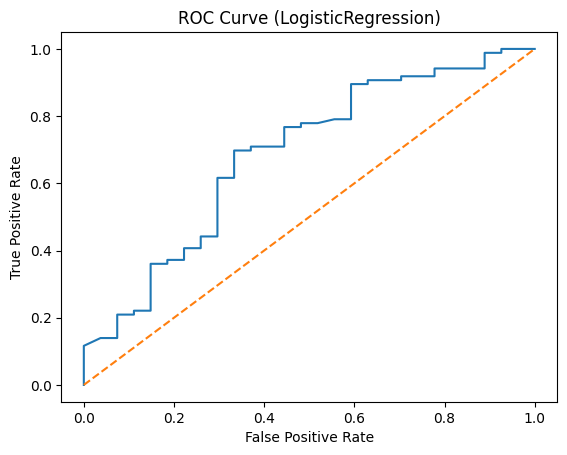

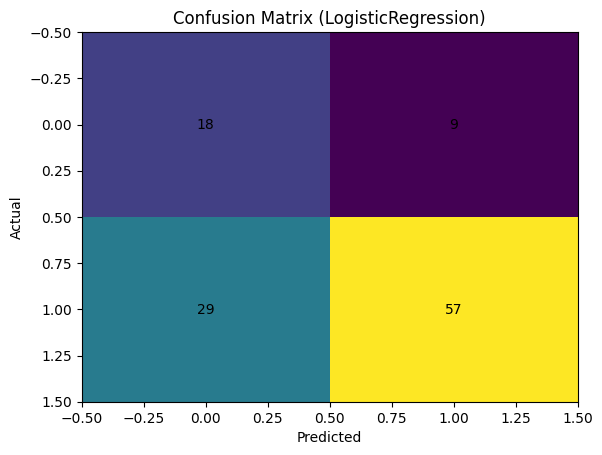

,feature,coefficient
3,Time,0.982414
2,Monetary,-0.606002
1,Frequency,-0.606002
6,RecencyInverse,-0.407187
0,Recency,0.407187
4,DonationRate,0.214734
5,AvgAmountPerDonation,0.000000


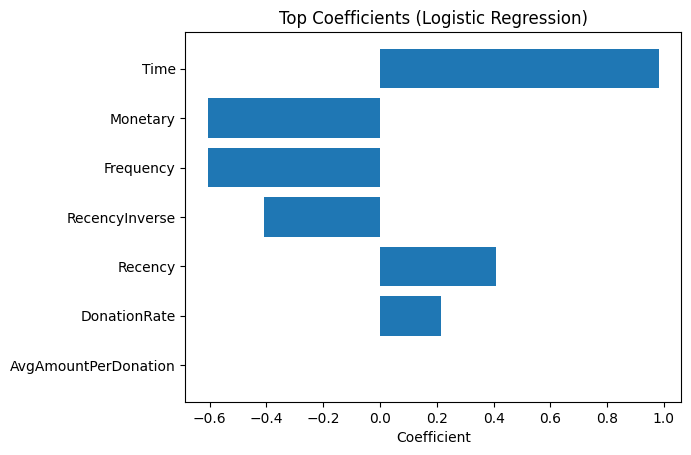

In [49]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Retrain on Train+Val
X_tr_full = pd.concat([X_train, X_val], axis=0)
y_tr_full = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_tr_full, y_tr_full)

# Test predictions
y_test_pred = best_model.predict(X_test)
try:
    y_test_prob = best_model.predict_proba(X_test)[:,1]
except:
    try:
        y_test_prob = best_model.decision_function(X_test)
    except:
        y_test_prob = None

# Metrics
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, zero_division=0)
rec = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
auc = roc_auc_score(y_test, y_test_prob) if (y_test_prob is not None) and (y_test.nunique()==2) else np.nan

print({"model": best_name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc})
print("\nClassification report:\n", classification_report(y_test, y_test_pred, zero_division=0))

# ROC curve
if (y_test_prob is not None) and (y_test.nunique()==2):
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"ROC Curve ({best_name})")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.show()

# Feature Importance / Coefficients
if "RandomForest" in best_name:
    rf = best_model.named_steps.get("model")
    if rf is not None and hasattr(rf, "feature_importances_"):
        importances = rf.feature_importances_
        imp_df = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
        display(imp_df.head(15))
        plt.figure()
        top = imp_df.head(10)
        plt.barh(top["feature"][::-1], top["importance"][::-1])
        plt.title("Top Feature Importances (RandomForest)")
        plt.xlabel("Importance")
        plt.show()
elif "LogisticRegression" in best_name:
    coef = best_model.named_steps["model"].coef_[0]
    coef_df = pd.DataFrame({"feature": X.columns, "coefficient": coef}).sort_values("coefficient", key=lambda s: np.abs(s), ascending=False)
    display(coef_df.head(15))
    plt.figure()
    top = coef_df.head(10)
    plt.barh(top["feature"][::-1], top["coefficient"][::-1])
    plt.title("Top Coefficients (Logistic Regression)")
    plt.xlabel("Coefficient")
    plt.show()
